In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from lib.llm.gpt import GPTClient
from dotenv import load_dotenv
import os

load_dotenv()

API_KEY = os.environ["OPEN_AI_API_KEY"]

client = GPTClient(API_KEY)

INFO:lib.log:...Using tool NewsMediaTool with args "California rainy winter 2023"...
INFO:lib.log:......Retrieving www.nytimes.com article with title A Very Wet Winter Has Eased California’s Drought, but Water Woes Remain......
INFO:lib.log:......Retrieving www.nytimes.com article with title What Does All This Rain Mean for California’s Drought?......
INFO:lib.log:......Retrieving www.nytimes.com article with title Powerful Storm Strikes California, From Surging Seas to Mountain Snow......
INFO:lib.log:......Retrieving www.nytimes.com article with title How Climate Change Is Shaping California’s Winter Storms......
INFO:lib.log:......Retrieving Washington Post article with title New winter storm could push California’s snowpack to record high......
INFO:lib.log:......Retrieving Washington Post article with title The science behind California’s extremely wet winter, in maps......
INFO:lib.log:......Retrieving Washington Post article with title In California, a drought turned to floods. 

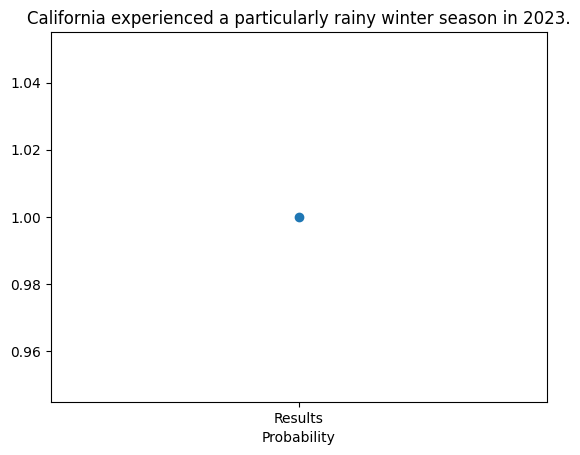

In [3]:
from core.tools.toolbelt import Toolbelt
from core.tools.query.news_media import NewsMediaTool
from lib.log import logger, AgentLogLevel
from core.assembly.research import ResearchAssembly
from core.modelers.modeler import Modeler, Parameter
from matplotlib import pyplot

logger.set_log_level(AgentLogLevel.OUTPUT)

TIMES_TO_RUN = 1

modeler = Modeler(
    client,
    ResearchAssembly,
    parameters=[
        Parameter(
            independent_variable="Results",
            parameters={
                "toolbelt": Toolbelt(
                    client,
                    tools=[
                        NewsMediaTool(client, n_articles=10, start_date="2023-01-01", end_date="2023-05-01")
                    ]
                ),
                "n_agents": 10,
                "max_articles_per_agent": 8,
            }
        )
        for i in range(TIMES_TO_RUN)
    ],
    max_concurrency=1
)
results = await modeler.model(
    "California experienced a particularly rainy winter season in 2023.",
)
variables = modeler.get_plot_variables(results)

pyplot.scatter(*variables)
pyplot.ylabel("Probability")
pyplot.title("California experienced a particularly rainy winter season in 2023.")
pyplot.show()

INFO:lib.log:...Using tool NewsMediaTool with args "California dry winter season 2023"...
INFO:lib.log:......Retrieving www.nytimes.com article with title A Very Wet Winter Has Eased California’s Drought, but Water Woes Remain......
INFO:lib.log:......Retrieving Washington Post article with title In California, a drought turned to floods. Forecasters didn’t see it coming.......
INFO:lib.log:......Retrieving www.nytimes.com article with title How Did a La Niña Winter Become So Rainy?......
INFO:lib.log:......Retrieving www.nytimes.com article with title What Does All This Rain Mean for California’s Drought?......
INFO:lib.log:......Retrieving www.nytimes.com article with title When Will the Rain End in California? Soon, but Not Soon Enough......
INFO:lib.log:......Retrieving Washington Post article with title California storms left behind a ‘generational snowpack.’ What that means.......
INFO:lib.log:......Retrieving Washington Post article with title Years of drought force shutdown of 

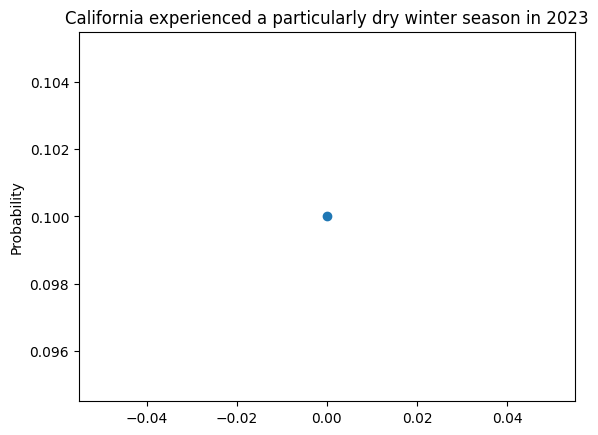

In [11]:
from core.tools.toolbelt import Toolbelt
from core.tools.query.news_media import NewsMediaTool
from lib.log import logger, AgentLogLevel
from core.assembly.research import ResearchAssembly
from core.modelers.modeler import Modeler, Parameter
from matplotlib import pyplot

logger.set_log_level(AgentLogLevel.OUTPUT)

TIMES_TO_RUN = 1

modeler = Modeler(
    client,
    ResearchAssembly,
    parameters=[
        Parameter(
            independent_variable=i,
            parameters={
                "toolbelt": Toolbelt(
                    client,
                    tools=[
                        NewsMediaTool(client, n_articles=10, start_date="2023-01-01", end_date="2023-05-01")
                    ]
                ),
                "n_agents": 10,
                "max_articles_per_agent": 8,
            }
        )
        for i in range(TIMES_TO_RUN)
    ],
    max_concurrency=1
)
results = await modeler.model(
    "California experienced a particularly dry winter season in 2023.",
)
variables = modeler.get_plot_variables(results)

pyplot.scatter(*variables)
pyplot.ylabel("Probability")
pyplot.title("California experienced a particularly dry winter season in 2023")
pyplot.show()

In [12]:
from core.tools.toolbelt import Toolbelt
from core.tools.query.news_media import NewsMediaTool
from lib.log import logger, AgentLogLevel
from core.assembly.debate import DebateAssembly
from core.modelers.modeler import Modeler, Parameter

logger.set_log_level(AgentLogLevel.OUTPUT)
date_ranges = [
    ('2022-05-01', '2022-06-01'),
    ('2022-06-01', '2022-07-01'),
    ('2022-07-01', '2022-08-01'),
    ('2022-08-01', '2022-09-01'),
    ('2022-09-01', '2022-10-01'),
    ('2022-10-01', '2022-11-05'),
]

modeler = Modeler(
    client,
    DebateAssembly,
    parameters=[
        Parameter(
            independent_variable=range[1],
            parameters={
                "n_rounds": 10,
                "max_concurrency": 10,
                "max_articles_per_round": 5,
                "toolbelt": Toolbelt(
                    client,
                    [NewsMediaTool(client, n_articles=10,start_date=range[0], end_date=range[1])]
                ),
            } 
        )
        for range in date_ranges
    ],
    max_concurrency=1
)

results = await modeler.model(
    "Democrats will maintain control of the Senate in the 2022 November Midterm elections.",
)

INFO:lib.log:...Using tool NewsMediaTool with args "2022 Senate midterm elections control prediction"...
INFO:lib.log:......Retrieving www.nytimes.com article with title Pennsylvania G.O.P. Senate Race Is Deadlocked; Cawthorn Falls to Defeat......
INFO:lib.log:......Retrieving www.nytimes.com article with title The Midterm Primary Elections Are Underway. Here’s What to Know. (Published 2022)......
INFO:lib.log:......Retrieving www.nytimes.com article with title Republican ‘Chaos’ in Pennsylvania Threatens to Upend the Midterms......
INFO:lib.log:......Retrieving www.nytimes.com article with title David Perdue makes racist remarks about Stacey Abrams as he ends a lackluster campaign.......
INFO:lib.log:......Retrieving www.nytimes.com article with title Democrats Aim to Use Abortion Rights to Jolt State Legislative Races (Published 2022)......
INFO:lib.log:......Retrieving www.nytimes.com article with title In Trump’s Shadow, Ohio Republicans Campaign Ahead of Tuesday’s Primary (Publish

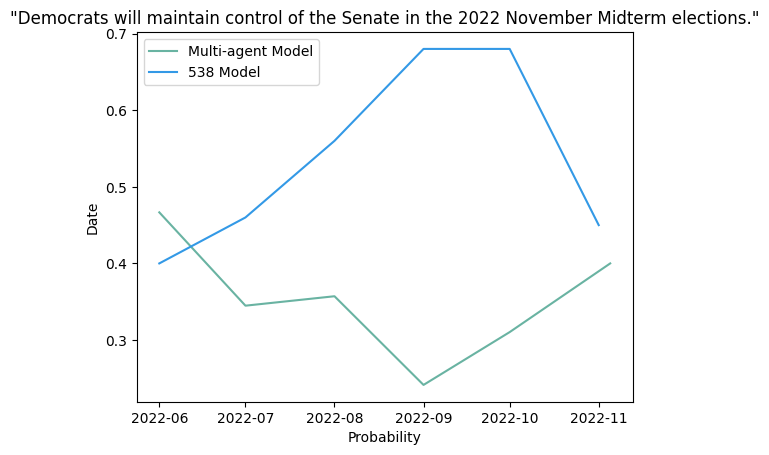

In [13]:
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import pyplot

COLOR_SENTIMENT = "#69b3a2"
COLOR_SAP = "#3399e6"
  
variables = modeler.get_plot_variables(results)


# plotting the points 

pyplot.plot([datetime(int(r[0:4]), int(r[5:7]), int(r[8:10])) for r in variables[0]], variables[1], color=COLOR_SENTIMENT, label="Multi-agent Model")
pyplot.plot([datetime(int(r[0:4]), int(r[4:6]), int(r[6:8])) for r in ['20220601', '20220701', '20220801', '20220901', '20221001', '20221101']], [1 - r for r in [0.60, 0.54, 0.44, 0.32, 0.32, 0.55]], color=COLOR_SAP, label="538 Model")

pyplot.xlabel("Probability")
pyplot.ylabel("Date")

pyplot.legend(loc="upper left")
  
# giving a title to my graph
pyplot.title('"Democrats will maintain control of the Senate in the 2022 November Midterm elections."')
  
# function to show the plot
pyplot.show()

In [14]:
from core.tools.toolbelt import Toolbelt
from core.tools.query.news_media import NewsMediaTool
from lib.log import logger, AgentLogLevel
from core.assembly.debate import DebateAssembly
from core.assembly.research import ResearchAssembly
from core.modelers.modeler import Modeler, Parameter
from matplotlib import pyplot

logger.set_log_level(AgentLogLevel.OUTPUT)

sources = [
    "nytimes.com",
    "washingtonpost.com",
    "wsj.com",
    "economist.com",
    "cnn.com",
    "foxnews.com",
]

modeler = Modeler(
    client,
    ResearchAssembly,
    parameters=[
        Parameter(
            independent_variable=source,
            parameters={
                "toolbelt": Toolbelt(
                    client,
                    tools=[
                        NewsMediaTool(client, n_articles=20, start_date="2022-06-01", end_date="2023-05-01", only_include_sources=[source])
                    ]
                ),
                "n_agents": 50,
                "max_articles_per_agent": 5,
                "max_concurrency": 20,
            }
        )
        for source in sources
    ],
    max_concurrency=1
)
results = await modeler.model(
    "The Biden administration has not done an effective job of managing inflation.",
)
variables = modeler.get_plot_variables(results)

INFO:lib.log:...Using tool NewsMediaTool with args "Biden administration inflation management"...
INFO:lib.log:......Retrieving www.nytimes.com article with title Sobering Inflation Report Dampens Biden’s Claims of Economic Progress......
INFO:lib.log:......Retrieving www.nytimes.com article with title US Inflation Rose 8.3 Percent in August: CPI Report: Price Pressures Remain Stubbornly High......
INFO:lib.log:......Retrieving www.nytimes.com article with title September Inflation Report: Prices Rise Faster Than Expected......
INFO:lib.log:......Retrieving www.nytimes.com article with title White House Expects Slower Economic Growth in 2022 Than Originally Projected......
INFO:lib.log:......Retrieving www.nytimes.com article with title Biden Weighs Tariff Rollback to Ease Inflation, Even a Little Bit......
INFO:lib.log:......Retrieving www.nytimes.com article with title White House Struggles to Talk About the ‘Problem From Hell’......
INFO:lib.log:......Retrieving www.nytimes.com arti

[{'role': 'system', 'content': 'You are a research analyst named Hank. You are preparing for a debate where you must make the following argument: 1. Strongly held beliefs: The Biden administration has not done an effective job of managing inflation. Here is what you have learned so far in your research: 1. www.nytimes.com article entitled "Sobering Inflation Report Dampens Biden’s Claims of Economic Progress": - The Consumer Price Index (CPI) report for August contained unwelcome news for President Biden and his administration, as inflation had not cooled as White House economists and other forecasters had hoped, and that the workers had lost buying power over the last year as prices increased faster than wages. - Another report, from the Census Bureau, showed that the typical American household saw its inflation-adjusted income fall slightly in 2021 from 2020, and income inequality has increased last year for the first time in a decade. - High prices loom as the top issue for voters i

INFO:lib.log:Hank: I must respectfully disagree with my opponent's perspective on the Biden administration's management of inflation. The evidence shows that the administration has taken proactive measures to address this issue.

Firstly, as reported in the New York Times, the Biden administration established a task force aimed at addressing supply chain disruptions and increasing domestic production of critical goods. This is a crucial step towards mitigating inflationary pressure caused by disruptions in global supply chains due to the COVID-19 pandemic.

Secondly, the administration has invested in infrastructure projects aimed at modernizing transportation and logistics networks. This not only helps to address supply chain disruptions but also creates jobs and boosts economic growth.

Moreover, the administration plans to increase domestic oil production while investing in renewable energy sources. This is an important step towards reducing our dependence on foreign oil and mitigat

ClientConnectorError: Cannot connect to host www.bloomberg.com:443 ssl:default [Connect call failed ('151.101.41.73', 443)]

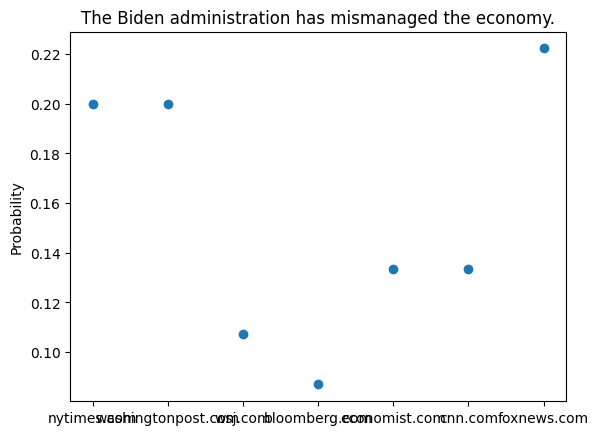

In [11]:
pyplot.scatter(*variables)
pyplot.ylabel("Probability")
pyplot.title("The Biden administration has not done an effective job of managing inflation.")
pyplot.show()